In [1]:
from lib.hamiltonian import H_B, H_D, H_P
from lib.time import S
from lib import X, D
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from joblib import Memory
import itertools

memory = Memory(location=".joblib_cache", verbose=0)

beta = -1
N = 3
alpha_values = np.linspace(10**(-5), 3, 500)

After we have imported all of our dependencies, we can go ahead and implement the Time-dependent Schrodinger equation which was proposed by Yves Rezus.



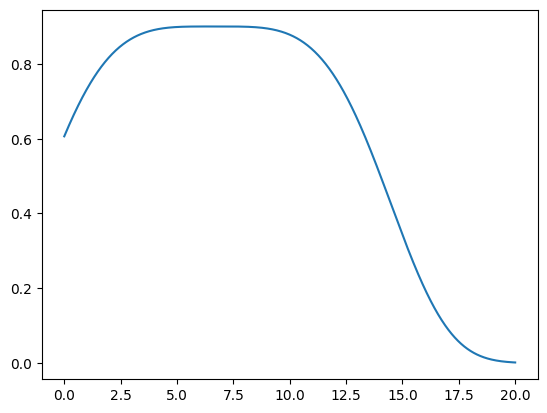

In [2]:
x = np.linspace(0, D, 1000)

y = S(x)

plt.plot(x, y)
plt.show()

To first understand how the energies change in this new scheme we should look at how the hamiltonian changes as we tune $ \gamma $ from 0 -> 1. 

$$
 H = \gamma*H_f + (1 - \gamma)*H_i
$$

In [3]:
def hamiltonian_energies(N):
    energies = []
    gamma_vals = []
    vecs = []
    t = 0.0
    beta = 1
    alpha = 6

    Hi = beta * H_D(N, X)
    Hf = H_B(N) + alpha * H_P(N)

    Tf = 3
    gamma = 0
    dt = 0.05
    tvals = np.arange(0, Tf, dt)

    for t in tvals:
        gamma = t/Tf
        H = gamma * Hf + (1 - gamma) * Hi
        eigvals, vec = np.linalg.eigh(H)
        energies.append(eigvals)
        vecs.append(vec)
        gamma_vals.append(gamma)

    return np.array(energies), np.array(vecs), gamma_vals

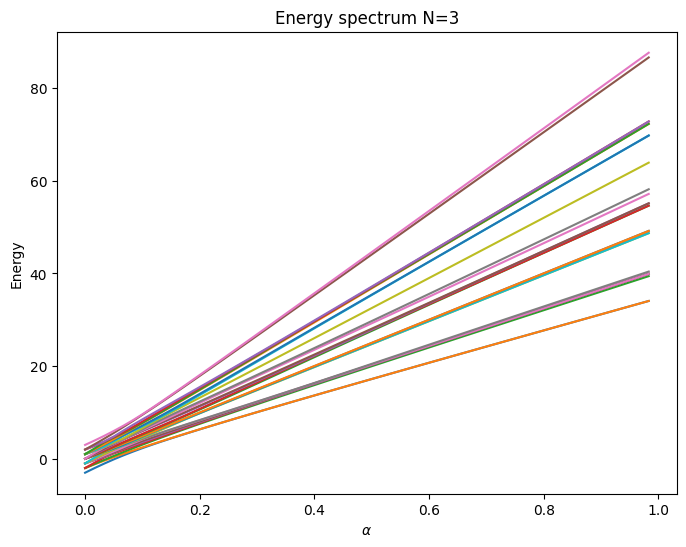

In [4]:
energies, vecs, gamma_vals = hamiltonian_energies(N)

plt.figure(figsize=(8, 6))
for i in range(energies.shape[1]):
    plt.plot(gamma_vals, energies[:, i])
plt.xlabel(r"$\alpha$")
plt.ylabel("Energy")
plt.title(f"Energy spectrum {N=}")
plt.show()

We can no see how the energy spectrum looks 

(1, -1, 0)
(-1, 1, 0)


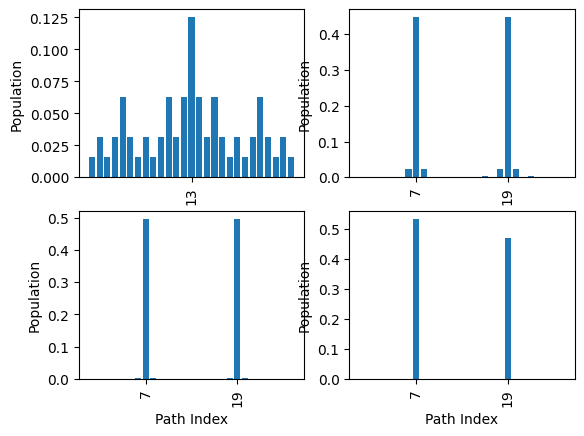

In [5]:
@memory.cache
def all_move_sequences(N):
    moves = (1, 0, -1)
    return list(itertools.product(moves, repeat=N))

vec = np.array([np.abs(v[:, 0])**2 for v in vecs])
fig, axes = plt.subplots(2, 2)
indices = np.arange(vecs.shape[1])
alpha_indices = np.linspace(0, len(vec)-1, 4, dtype=int)
selected_eigvecs = [vec[i] for i in alpha_indices]
moves = all_move_sequences(N)
for i, eigvec in enumerate(selected_eigvecs):
    ax = axes.flat[i]
    ax.bar(indices, eigvec, linewidth=1)
    ax_ids = []
    for j in range(len(eigvec)):
        if eigvec[j] > 0.1:
            ax_ids.append(j)
    ax.set_xlabel("Path Index")
    ax.set_ylabel("Population")
    ax.set_xticks(ax_ids)
    ax.set_xticklabels(ax_ids, rotation=90)
last = selected_eigvecs[-1]
ind = np.argwhere(last > 1e-2)
for i in ind:
    print(moves[i[0]])

In the plot above we can see which state we should end up in. 

In [6]:
@memory.cache
def yves_TDSE(gamma, N, Hi, Hf, T, steps=3000):
    dt = T / steps
    psi = 1/np.sqrt(3**N)*np.ones(3**N)
    eA = sp.linalg.expm(-1j * gamma * Hf * dt**2 / 4.0)
    MA = sp.linalg.expm(-1j * gamma * Hf * dt**2 / 2.0)
    eB = sp.linalg.expm(-1j * Hi * dt + 1j * gamma * Hi * dt**2 / 2.0)
    MB = sp.linalg.expm(1j * gamma * Hi * dt**2)

    # Time-stepping using n index (clear and robust)
    for n in range(steps-1):
        # Strang step using current eA, eB
        psi = eA @ eB @ eA @ psi

        # update eA and eB for next step using the recursion
        eA = MA @ eA
        eB = MB @ eB

    # final normalization & sanity
    psi /= np.linalg.norm(psi)
    return psi



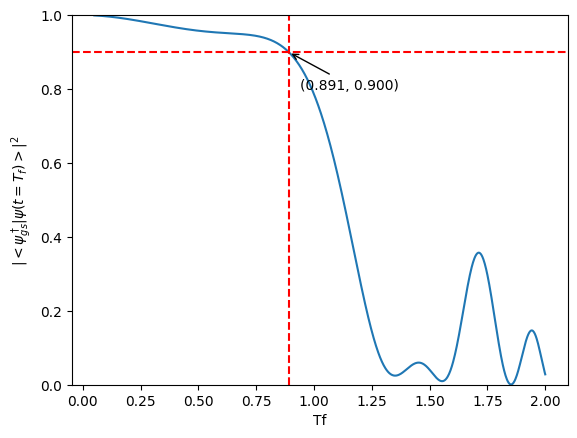

In [11]:

fidelities = []
nsteps = 1000
Tf = 3
ts = np.linspace(0.05, 2, nsteps)
#ts = np.linspace(0.5, 3, nsteps)
f_all = False
i = 0
#for t in ts:
psi_gs = 1/np.sqrt(3**N)*np.ones(3**N)
g = []
def gamma(t):
    return t/Tf

for t in ts:
    gam = gamma(t)
    Hf = H_B(N) + 3 * H_P(N)
    Hi = beta * H_D(N, X)
    Hi = (1 - gam) * Hi
    Hf = gam * Hf
    psi = yves_TDSE(gam, N, Hi, Hf, T=t)
    if f_all:
        probability = np.abs(psi)**2
        fidelity = probability
    else:
        fidelity = np.abs(np.vdot(psi_gs, psi))**2
    fidelities.append(fidelity)
    g.append(gam)

plt.figure()
plt.ylim(0, 1)
plt.xlabel("Tf")
plt.ylabel(r"$ |<\psi^\dagger_{gs} | \psi(t=T_f)>|^2 $")
plt.plot(ts, fidelities)
search_point = 0.8

if not f_all:
    for yval in fidelities:
        if search_point +0.1 > yval > search_point - 0.1:
            index = fidelities.index(yval)
            xval = ts[index]
            # plt.plot(gammas[index], f, 'ro')
            plt.axhline(y=yval,  color='r', linestyle='--', label='Ideal Fidelity')
            plt.axvline(x=xval,  color='r', linestyle='--', label='Ideal Fidelity')
    
            # annotate the point
            plt.annotate(f'({xval:.3f}, {yval:.3f})',
                 xy=(xval, yval),
                 xytext=(xval + 0.05, yval - 0.1),
                 arrowprops=dict(facecolor='black', arrowstyle='->'))
    
            break
plt.show()

In [8]:
print(fidelities)

[np.float64(0.9991963978104341), np.float64(0.9991337222568436), np.float64(0.9990688004109655), np.float64(0.9990016443844898), np.float64(0.9989322663727602), np.float64(0.9988606786562505), np.float64(0.9987868935984481), np.float64(0.9987109236497714), np.float64(0.9986327813431938), np.float64(0.9985524792976799), np.float64(0.9984700302184635), np.float64(0.9983854468927346), np.float64(0.9982987421952998), np.float64(0.9982099290856667), np.float64(0.9981190206092613), np.float64(0.9980260298943775), np.float64(0.9979309701580776), np.float64(0.9978338547008411), np.float64(0.9977346969090811), np.float64(0.9976335102556793), np.float64(0.9975303082972872), np.float64(0.9974251046771531), np.float64(0.9973179131247556), np.float64(0.9972087474523296), np.float64(0.9970976215608007), np.float64(0.9969845494351358), np.float64(0.9968695451455627), np.float64(0.9967526228483323), np.float64(0.9966337967850296), np.float64(0.9965130812803129), np.float64(0.9963904907454023), np.floa